# Reducción de Dimensionalidad y Benchmarking de Modelos (Core)
**Descripción:**

En este proyecto, aplicarás una combinación de técnicas avanzadas, comenzando por un análisis de reducción de dimensionalidad (como PCA) y luego realizarás un benchmark de diferentes modelos de machine learning para encontrar el que mejor se adecue a los objetivos específicos del dataset que has elegido.



**Objetivo:**

El objetivo es realizar un análisis exhaustivo que comience con la reducción de dimensionalidad para simplificar el dataset y luego probar varios modelos de machine learning para determinar cuál ofrece el mejor rendimiento en términos de precisión, recall, F1-score u otras métricas relevantes para tu problema.

## Funciones a utilizar

In [23]:
# Función para encontrar valores atípicos POR el método de los cuartiles y el rango intercuartílico (IQR). chatgpt
def identificar_atipicos_IQR(df, columnas):
    atipicos = pd.DataFrame()  # DataFrame para almacenar filas con valores atípicos

    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Definir límites para valores atípicos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar filas que tienen valores atípicos
        filas_atipicas = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

        # Concatenar filas atípicas al DataFrame de atípicos
        atipicos = pd.concat([atipicos, filas_atipicas])

    return atipicos.drop_duplicates()  # Eliminar duplicados
def ver_resumen_nulos(df):
    qna=df.isnull().sum(axis=0)
    qsna=df.shape[0]-qna

    ppna=round(100*(qna/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    resumen_nulos =na.sort_values(by='Na en %',ascending=False)
    return resumen_nulos
def desc(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas con el porcentaje de std/mean incluido.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    return df_describe

def desc_ceros(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas filtrando columnas con mínimo o máximo igual a cero,
    e incluye el porcentaje de std/mean.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean para las columnas filtradas.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    # Filtrar las columnas donde el mínimo o el máximo sea igual a cero
    df_describe = df_describe[(df_describe['min'] == 0) | (df_describe['max'] == 0)]

    return df_describe
def imprimir_bigotes(serie):
    """
    Calcula e imprime los bigotes de una serie de datos.

    Parameters:
    serie (pd.Series): La serie de datos para la cual se calcularán los bigotes.

    Returns:
    None: Imprime los valores de los bigotes.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los bigotes
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Límite inferior (bigote inferior): {limite_inferior}")
    print(f"Límite superior (bigote superior): {limite_superior}")
    # Retornar los valores para poder usarlos en otras funciones
    return limite_inferior, limite_superior
def imprimir_bigotes_por_grupo(df, columna, target):
    """
    Imprime los bigotes de los datos por grupo de una columna específica.

    Parameters:
    df (pd.DataFrame): El DataFrame con los datos.
    columna (str): La columna sobre la que se calcularán los bigotes.
    target (str): La columna que contiene las etiquetas de grupo (por ejemplo, 'Species').

    Returns:
    None: Imprime los bigotes por cada grupo.
    """
    print(f"\nBigotes de {columna} por grupo:")
    for species in df[target].unique():
        print(f"\nEspecie: {species}")
        species_data = df[df[target] == species][columna]
        # Imprimir los bigotes solo una vez
        limite_inferior, limite_superior = imprimir_bigotes(species_data)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
def plot_varianza(prm_pca):
    plt.figure(figsize=(12, 6))

    # 1. Ganancia de varianza explicada por cada componente
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(prm_pca.explained_variance_ratio_) + 1),
            prm_pca.explained_variance_ratio_, color='skyblue')
    plt.title('Ganancia de varianza explicada por cada componente')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Ganancia de Varianza Explicada (%)')
    plt.grid(True)

    # Etiquetas en las barras
    for i, v in enumerate(prm_pca.explained_variance_ratio_):
        plt.text(i + 1, v + 0.01, f'{v*100:.2f}%', ha='center')

    # 2. Varianza acumulada
    explained_variance_cumulative = prm_pca.explained_variance_ratio_.cumsum()
    explained_variance_gain = np.diff(explained_variance_cumulative, prepend=0)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variance_cumulative) + 1),
             explained_variance_cumulative, marker='o', linestyle='--', color='orange')
    plt.title('Variación Explicada Acumulada')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.axhline(y=0.90, color='r', linestyle='--', label=f'90% Umbral')
    plt.axvline(x=np.argmax(explained_variance_cumulative >= 0.90) + 1,
                color='g', linestyle='--', label='Número óptimo de componentes')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Mostrar información en consola
    print("Variación explicada acumulada y ganancia:")
    for i, variance in enumerate(explained_variance_cumulative, 1):
        print(f"Componente {i}: {variance:.2%} ({explained_variance_gain[i-1]*100:.2f}%)")

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [2]:
import pandas as pd

# Crear el DataFrame a partir de una lista de diccionarios
data = [
    {"Columna": "CUST_ID", "Tipo": "Object", "Descripción": "Identificación única del cliente", "Ejemplo": "C0001"},
    {"Columna": "BALANCE", "Tipo": "Float64", "Descripción": "Monto del Disponible del cliente Limite - Consumos", "Ejemplo": 1000.0},
    {"Columna": "BALANCE_FREQUENCY", "Tipo": "Float64", "Descripción": "Frecuencia con la que el cliente ha utilizado su tarjeta", "Ejemplo": 1},
    {"Columna": "PURCHASES", "Tipo": "Float64", "Descripción": "Monto total de compras realizadas por el cliente", "Ejemplo": 200.0},
    {"Columna": "ONEOFF_PURCHASES", "Tipo": "Float64", "Descripción": "Monto Máximo de compras realizadas en una sola vez", "Ejemplo": 150.0},
    {"Columna": "INSTALLMENTS_PURCHASES", "Tipo": "Float64", "Descripción": "Monto total de compras realizadas en cuotas", "Ejemplo": 50.0},
    {"Columna": "CASH_ADVANCE", "Tipo": "Float64", "Descripción": "Monto total de avances de efectivo realizados por el cliente", "Ejemplo": 100.0},
    {"Columna": "PURCHASES_FREQUENCY", "Tipo": "Float64", "Descripción": "Frecuencia con la que el cliente realiza compras", "Ejemplo": 0.75},
    {"Columna": "ONEOFF_PURCHASES_FREQUENCY", "Tipo": "Float64", "Descripción": "Frecuencia con la que el cliente realiza compras en un solo pago", "Ejemplo": 0.25},
    {"Columna": "PURCHASES_INSTALLMENTS_FREQUENCY", "Tipo": "Float64", "Descripción": "Frecuencia con la que el cliente realiza compras en cuotas", "Ejemplo": 0.5},
    {"Columna": "CASH_ADVANCE_FREQUENCY", "Tipo": "Float64", "Descripción": "Frecuencia con la que el cliente realiza avances de efectivo", "Ejemplo": 0.1},
    {"Columna": "CASH_ADVANCE_TRX_FREQUENCY", "Tipo": "Float64", "Descripción": "Cantidad de transacciones de avances de efectivo", "Ejemplo": 0.05},
    {"Columna": "PURCHASES_TRX_FREQUENCY", "Tipo": "Float64", "Descripción": "Cantidad de transacciones de compras", "Ejemplo": 0.9},
    {"Columna": "CREDIT_LIMIT", "Tipo": "Float64", "Descripción": "Límite de crédito del cliente", "Ejemplo": 5000.0},
    {"Columna": "PAYMENTS", "Tipo": "Float64", "Descripción": "Monto total de pagos realizados por el cliente", "Ejemplo": 300.0},
    {"Columna": "MINIMUM_PAYMENTS", "Tipo": "Float64", "Descripción": "Total de Pagos Mínimos del cliente", "Ejemplo": 50.0},
    {"Columna": "PRC_FULL_PAYMENT", "Tipo": "Float64", "Descripción": "Porcentaje del pago total que ha realizado el cliente", "Ejemplo": 0.2},
    {"Columna": "TENURE", "Tipo": "Int64", "Descripción": "Duración del cliente con la tarjeta de crédito en meses", "Ejemplo": 12}
]

# Crear el DataFrame
df_diccionario = pd.DataFrame(data)


# Instrucciones:
## 1. Selección del dataset:
  - Utiliza el dataset que seleccionaste para el Proyecto 2 o elige uno adecuado de Kaggle que se relacione con tu área de interés. El dataset debe tener al menos 10 características y una variable objetivo clara.

  

## Seleccionamos el dataset del core 6. Tarjetas de crédito.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Acceder al archivo
file_path = '/content/telco-customer-churn.csv'
df = pd.read_csv(file_path)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4         

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
customerID,7043,0,0.0
DeviceProtection,7043,0,0.0
TotalCharges,7043,0,0.0
MonthlyCharges,7043,0,0.0
PaymentMethod,7043,0,0.0
PaperlessBilling,7043,0,0.0
Contract,7043,0,0.0
StreamingMovies,7043,0,0.0
StreamingTV,7043,0,0.0
TechSupport,7043,0,0.0


Hay valores nulos y no validos.

In [9]:
# Detectar columnas con valores únicos ['Yes', 'No']
yes_no_columns = [col for col in df.columns if sorted(df[col].dropna().unique()) == ['No', 'Yes']]
print("Columnas con valores 'Yes' y 'No':", yes_no_columns)
# Aplicar el mapeo 'Yes' -> 1 y 'No' -> 0 a todas las columnas de una vez usando map y itertools
df[yes_no_columns] = pd.DataFrame(
    map(lambda col: df[col].map({'Yes': 1, 'No': 0}), yes_no_columns)
).T.set_axis(yes_no_columns, axis=1)

Columnas con valores 'Yes' y 'No': ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


In [10]:
data_dict = {
    'customerID': 'object',
    'gender': 'category',
    'SeniorCitizen': 'bool',
    'Partner': 'bool',
    'Dependents': 'bool',
    'tenure': 'int64',
    'PhoneService': 'bool',
    'MultipleLines': 'category',
    'InternetService': 'category',
    'OnlineSecurity': 'category',
    'OnlineBackup': 'category',
    'DeviceProtection': 'category',
    'TechSupport': 'category',
    'StreamingTV': 'category',
    'StreamingMovies': 'category',
    'Contract': 'category',
    'PaperlessBilling': 'bool',
    'PaymentMethod': 'category',
    'MonthlyCharges': 'float64',
    'TotalCharges': 'float64',
    'Churn': 'bool'
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    df[column] = df[column].astype(dtype, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   bool    
 3   Partner           7043 non-null   bool    
 4   Dependents        7043 non-null   bool    
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   bool    
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [11]:
df.TotalCharges.unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [13]:
# Reemplazar espacios vacíos en 'TotalCharges' con NaN
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
# Convertir la columna a float64
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   bool    
 3   Partner           7043 non-null   bool    
 4   Dependents        7043 non-null   bool    
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   bool    
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

Ya no hay nulos ni valores invalidos.

In [14]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [15]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = df.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: df[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2,3
gender,Female,Male,None,None
SeniorCitizen,False,True,None,None
Partner,True,False,None,None
Dependents,False,True,None,None
PhoneService,False,True,None,None
MultipleLines,No phone service,No,Yes,None
InternetService,DSL,Fiber optic,No,None
OnlineSecurity,No,Yes,No internet service,None
OnlineBackup,Yes,No,No internet service,None
DeviceProtection,No,Yes,No internet service,None


In [16]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
TotalCharges,7032,11,0.16
customerID,7043,0,0.00
DeviceProtection,7043,0,0.00
MonthlyCharges,7043,0,0.00
PaymentMethod,7043,0,0.00
PaperlessBilling,7043,0,0.00
Contract,7043,0,0.00
StreamingMovies,7043,0,0.00
StreamingTV,7043,0,0.00
TechSupport,7043,0,0.00


In [17]:
df.TotalCharges.describe()

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


In [18]:
desc(df,'TotalCharges')

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000
%std/mean,99.280000


In [19]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[df.TotalCharges.isna()].T

,488,753,936,1082,1340,3331,3826,4380,5218,6670,6754
customerID,4472-LVYGI,3115-CZMZD,5709-LVOEQ,4367-NUYAO,1371-DWPAZ,7644-OMVMY,3213-VVOLG,2520-SGTTA,2923-ARZLG,4075-WKNIU,2775-SEFEE
gender,Female,Male,Female,Male,Female,Male,Male,Female,Male,Female,Male
SeniorCitizen,False,False,False,False,False,False,False,False,False,False,False
Partner,True,False,True,True,True,True,True,True,True,True,False
Dependents,True,True,True,True,True,True,True,True,True,True,True
tenure,0,0,0,0,0,0,0,0,0,0,0
PhoneService,False,True,True,True,False,True,True,True,True,True,True
MultipleLines,No phone service,No,No,Yes,No phone service,No,Yes,No,No,Yes,Yes
InternetService,DSL,No,DSL,No,DSL,No,No,No,No,DSL,DSL
OnlineSecurity,Yes,No internet service,Yes,No internet service,Yes,No internet service,No internet service,No internet service,No internet service,No,Yes


In [20]:
df.fillna(value={'TotalCharges': 0}, inplace=True)

In [25]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
tenure,0.0,0.0,0.00,72.00
MonthlyCharges,0.0,0.0,18.25,118.75
TotalCharges,0.0,0.0,0.00,8684.80


In [27]:
desc(df,numerical_columns)

,count,mean,std,min,25%,50%,75%,max,%std/mean
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00,75.87
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75,46.46
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80,99.43


In [28]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
customerID,7043,0,0.0
DeviceProtection,7043,0,0.0
TotalCharges,7043,0,0.0
MonthlyCharges,7043,0,0.0
PaymentMethod,7043,0,0.0
PaperlessBilling,7043,0,0.0
Contract,7043,0,0.0
StreamingMovies,7043,0,0.0
StreamingTV,7043,0,0.0
TechSupport,7043,0,0.0


## - Realiza una exploración inicial para entender las variables y la relación que tienen con la variable objetivo.

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


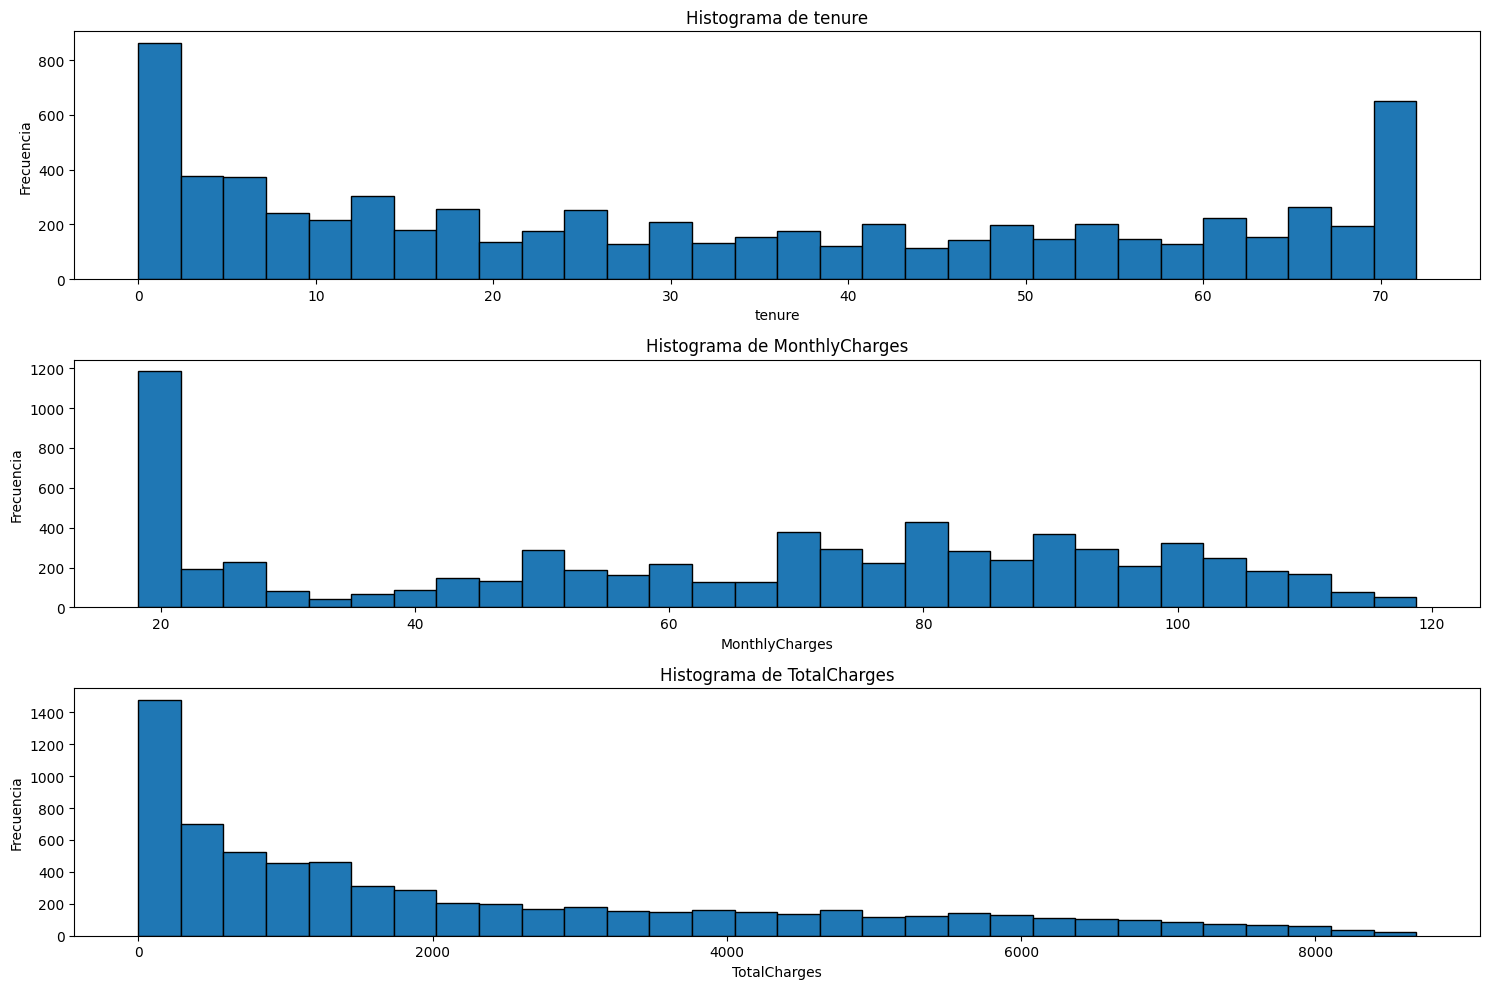

In [29]:
print(df[numerical_columns].describe())

# Configuración del tamaño de la gráfica
plt.figure(figsize=(15, 10))

# Crear un histograma para cada columna numérica
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    plt.hist(df[column].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   bool    
 3   Partner           7043 non-null   bool    
 4   Dependents        7043 non-null   bool    
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   bool    
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [31]:
# Seleccionar todas las numericas
columnas_numericas = df.select_dtypes(include=['number']).columns


In [32]:
desc(df, columnas_numericas)

,count,mean,std,min,25%,50%,75%,max,%std/mean
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00,75.87
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75,46.46
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80,99.43


In [35]:
from sklearn.preprocessing import StandardScaler

# Inicializar el StandardScaler
scaler = StandardScaler()


# Aplicar el escalador
df_scaled = df.copy()
df_scaled[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# Mostrar los datos escalados
print(df_scaled.head())


   customerID  gender  SeniorCitizen  Partner  Dependents    tenure  \
0  7590-VHVEG  Female          False     True       False -1.277445   
1  5575-GNVDE    Male          False    False       False  0.066327   
2  3668-QPYBK    Male          False    False       False -1.236724   
3  7795-CFOCW    Male          False    False       False  0.514251   
4  9237-HQITU  Female          False    False       False -1.236724   

   PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0         False  No phone service             DSL             No  ...   
1          True                No             DSL            Yes  ...   
2          True                No             DSL            Yes  ...   
3         False  No phone service             DSL            Yes  ...   
4          True                No     Fiber optic             No  ...   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              

## 2. Reducción de dimensionalidad:
  - Implementa un análisis de reducción de dimensionalidad utilizando PCA (u otra técnica adecuada). El objetivo es reducir el número de características, manteniendo al menos el 80-90% de la variabilidad original.

In [37]:
df_original = df.copy()

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['SeniorCitizen'] = label_encoder.fit_transform(df['SeniorCitizen'])


In [40]:
from sklearn.preprocessing import OneHotEncoder

# Replace 'sparse' with 'sparse_output'
encoder = OneHotEncoder(sparse_output=False)
encoded_cols = encoder.fit_transform(df[['InternetService']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['InternetService']))

df = pd.concat([df, encoded_df], axis=1).drop('InternetService', axis=1)

In [43]:
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No_service'})
encoded_cols = pd.get_dummies(df['MultipleLines'], prefix='MultipleLines', drop_first=True)
df = pd.concat([df, encoded_cols], axis=1).drop('MultipleLines', axis=1)


<ipython-input-43-feb44312c573>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No_service'})


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   customerID                   7043 non-null   object  
 1   gender                       7043 non-null   int64   
 2   SeniorCitizen                7043 non-null   int64   
 3   Partner                      7043 non-null   bool    
 4   Dependents                   7043 non-null   bool    
 5   tenure                       7043 non-null   int64   
 6   PhoneService                 7043 non-null   bool    
 7   OnlineSecurity               7043 non-null   category
 8   OnlineBackup                 7043 non-null   category
 9   DeviceProtection             7043 non-null   category
 10  TechSupport                  7043 non-null   category
 11  StreamingTV                  7043 non-null   category
 12  StreamingMovies              7043 non-null   category
 13  Con

In [46]:
numerical_columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [47]:
# Solo las columnas numericas
numerical_columns = df.select_dtypes(include=[np.number]).columns


In [48]:
numerical_columns

Index(['gender', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No'],
      dtype='object')

In [50]:
# Escalar los datos para tener media 0 y desviación estándar 1
X = df[numerical_columns]
y = df['Churn']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar un resumen de los datos escalados
print("Resumen de datos escalados:")
print(f"Media por característica (aproximadamente 0): {X_scaled.mean(axis=0)[:]}")
print(f"Desviación estándar por característica (aproximadamente 1): {X_scaled.std(axis=0)[:]}")

Resumen de datos escalados:
Media por característica (aproximadamente 0): [-2.21950024e-17 -4.84254598e-17 -2.42127299e-17 -6.40628478e-17
 -3.78323904e-17 -6.75938709e-17 -2.47171618e-17  1.43763084e-17]
Desviación estándar por característica (aproximadamente 1): [1. 1. 1. 1. 1. 1. 1. 1.]


In [51]:
# Paso 2: Aplicar PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)# Aplicar PCA al dataset escalado
X_pca = pca.transform(X_scaled)

# Paso 3: Determinar cuántos componentes principales se necesitan para capturar al menos el 90% de la variabilidad
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Encontrar el número de componentes necesarios para capturar el 90% de la varianza
num_components = (cumulative_variance >= 0.90).argmax() + 1  # +1 porque los índices son base 0

# Mostrar el número de componentes y la varianza acumulada
print(f"Se necesitan {num_components} componentes para capturar al menos el 90% de la variabilidad.")
print(f"Varianza acumulada: {cumulative_variance[num_components - 1]:.4f}")


Se necesitan 5 componentes para capturar al menos el 90% de la variabilidad.
Varianza acumulada: 0.9814


## - Visualiza los componentes principales.

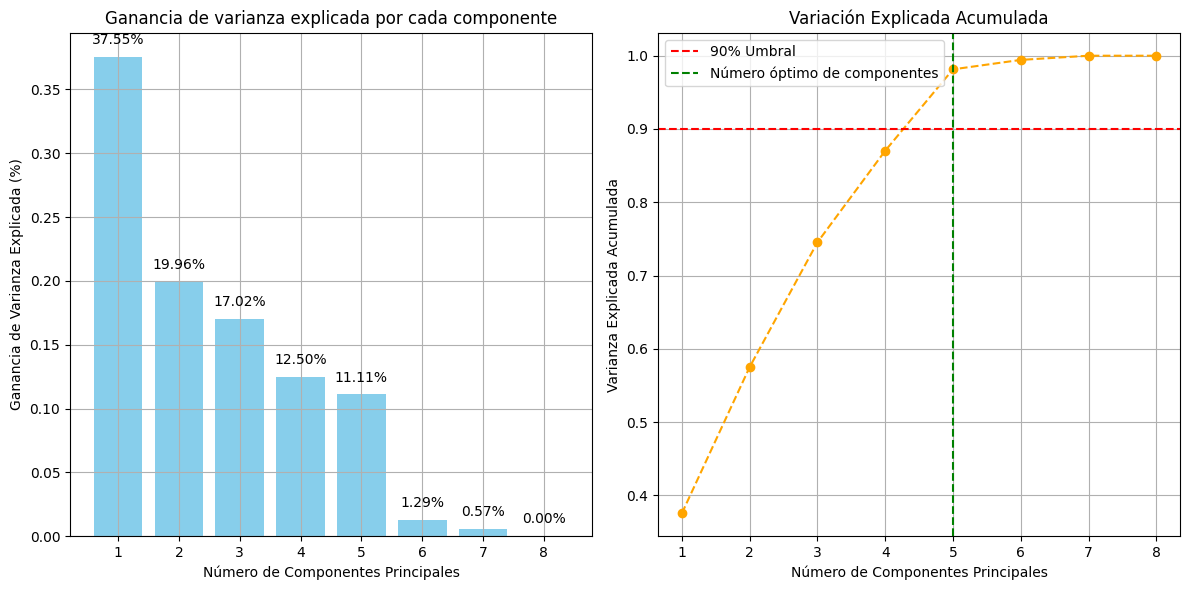

Variación explicada acumulada y ganancia:
Componente 1: 37.55% (37.55%)
Componente 2: 57.51% (19.96%)
Componente 3: 74.53% (17.02%)
Componente 4: 87.03% (12.50%)
Componente 5: 98.14% (11.11%)
Componente 6: 99.43% (1.29%)
Componente 7: 100.00% (0.57%)
Componente 8: 100.00% (0.00%)


In [52]:
plot_varianza(pca)

## Discute cómo contribuyen a la variabilidad del dataset.
## Contribución de los Componentes Principales a la Variabilidad del Dataset

A continuación se analiza cómo los **componentes principales** contribuyen a la variabilidad en el conjunto de datos. El objetivo es capturar la mayor cantidad de varianza con el menor número de componentes:

| Componente | Varianza Explicada (%) | Varianza Acumulada (%) |
|------------|------------------------|------------------------|
| 1          | 37.55                 | 37.55                 |
| 2          | 19.96                 | 57.51                 |
| 3          | 17.02                 | 74.53                 |
| 4          | 12.50                 | 87.03                 |
| 5          | 11.11                 | 98.14                 |
| 6          | 1.29                  | 99.43                 |
| 7          | 0.57                  | 100.00                |
| 8          | 0.00                  | 100.00                |

### Análisis
1. **Componente 1** explica **37.55%** de la varianza, siendo el más relevante.  
2. **Componente 2** añade **19.96%**, acumulando **57.51%**.  
3. Al incluir el **Componente 3**, se alcanza **74.53%** de la variabilidad.  
4. Los primeros **5 componentes** son suficientes para capturar **98.14%** de la varianza total, lo cual indica una gran **reducción dimensional** con mínima pérdida de información.  
5. Los componentes **6 y 7** aportan poca información adicional (**1.29%** y **0.57%**, respectivamente).  

La varianza acumulada sugiere que usar los **primeros 5 componentes** es adecuado para mantener la mayoría de la información del dataset. 🚀


### - Utiliza las características reducidas para simplificar el conjunto de datos.

In [53]:
# Dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verifica las dimensiones
print(f"Tamaño de entrenamiento: {X_train_scaled.shape}, Tamaño de prueba: {X_test_scaled.shape}")


# Mostrar un resumen de los datos escalados
print("Resumen de datos escalados:")
print(f"Media por característica (aproximadamente 0): {X_train_scaled.mean(axis=0)[:5]}")
print(f"Desviación estándar por característica (aproximadamente 1): {X_train_scaled.std(axis=0)[:5]}")

Tamaño de entrenamiento: (4930, 8), Tamaño de prueba: (2113, 8)
Resumen de datos escalados:
Media por característica (aproximadamente 0): [ 5.47679999e-17 -7.78282104e-17 -8.35932630e-17  1.44126316e-16
 -8.07107367e-17]
Desviación estándar por característica (aproximadamente 1): [1. 1. 1. 1. 1.]


In [54]:
numero_componentes = 5  # Es el mejor nro de componentes para obtner el 90% de variabilidad.
# Paso 2: Aplicar PCA
pca = PCA(n_components=numero_componentes)# Con None el grafico se genera con todos los componentes y se ve mejor.
pca.fit(X_train_scaled)# Aplicar PCA al dataset escalado
X_pca = pca.transform(X_train_scaled)

# Aplicar PCA a los datos de prueba
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Verificar dimensiones
print(f"Dimensiones de X_train reducidas: {X_train_pca.shape}")
print(f"Dimensiones de X_test reducidas: {X_test_pca.shape}")


Dimensiones de X_train reducidas: (4930, 5)
Dimensiones de X_test reducidas: (2113, 5)


In [55]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Before training the models, encode the target variable using LabelEncoder:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)  # Use the same encoder for the test data

# Definir el modelo
# Lista de modelos a evaluar
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Función para evaluar un modelo con múltiples métricas
def evaluate_model(model, X, y_encoded):
    cv_results = cross_val_score(model, X, y_encoded, cv=5, scoring='accuracy')
    print(f"Accuracy: {cv_results.mean():.2f} (+/- {cv_results.std():.2f})")

    # Evaluar otras métricas utilizando cross-validation
    precision = cross_val_score(model, X, y_encoded, cv=5, scoring='precision')
    recall = cross_val_score(model, X, y_encoded, cv=5, scoring='recall')
    f1 = cross_val_score(model, X, y_encoded, cv=5, scoring='f1')
    roc_auc = cross_val_score(model, X, y_encoded, cv=5, scoring='roc_auc')

    print(f"Precision: {precision.mean():.2f} (+/- {precision.std():.2f})")
    print(f"Recall: {recall.mean():.2f} (+/- {recall.std():.2f})")
    print(f"F1-score: {f1.mean():.2f} (+/- {f1.std():.2f})")
    print(f"ROC AUC: {roc_auc.mean():.2f} (+/- {roc_auc.std():.2f})")

# Evaluar cada modelo
for model in models:
    print(f"Evaluando {model}")
    evaluate_model(model, X_train_pca, y_train_encoded)

Evaluando LogisticRegression()
Accuracy: 0.79 (+/- 0.01)
Precision: 0.63 (+/- 0.02)
Recall: 0.45 (+/- 0.04)
F1-score: 0.53 (+/- 0.03)
ROC AUC: 0.81 (+/- 0.01)
Evaluando DecisionTreeClassifier()
Accuracy: 0.73 (+/- 0.01)
Precision: 0.49 (+/- 0.01)
Recall: 0.48 (+/- 0.03)
F1-score: 0.49 (+/- 0.01)
ROC AUC: 0.65 (+/- 0.01)
Evaluando RandomForestClassifier()
Accuracy: 0.77 (+/- 0.01)
Precision: 0.57 (+/- 0.01)
Recall: 0.45 (+/- 0.04)
F1-score: 0.50 (+/- 0.03)
ROC AUC: 0.78 (+/- 0.01)
Evaluando XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_del

4. Análisis comparativo de modelos:
  - Compara los modelos en base a las métricas obtenidas. Discute cuál de los modelos es más adecuado para resolver el problema en cuestión y por qué.
  - Si alguno de los modelos tiene un rendimiento significativamente inferior, analiza posibles causas y estrategias para mejorar el rendimiento (como ajustar hiperparámetros o utilizar técnicas de regularización).

## Comparación de Modelos de Machine Learning

| Modelo                   | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|--------------------------|----------|-----------|--------|----------|---------|
| **Logistic Regression**  | 0.79     | 0.63      | 0.45   | 0.53     | 0.81    |
| **Decision Tree**        | 0.73     | 0.49      | 0.48   | 0.49     | 0.65    |
| **Random Forest**        | 0.77     | 0.57      | 0.45   | 0.50     | 0.78    |
| **XGBoost**              | 0.78     | 0.60      | 0.46   | 0.52     | 0.80    |

---

### Análisis Comparativo de Modelos

1. **Rendimiento General**:
   - La **Regresión Logística** y **XGBoost** obtuvieron las métricas más altas.
   - **ROC AUC** indica que **Logistic Regression** (0.81) supera ligeramente a XGBoost (0.80).

2. **Logistic Regression**:
   - Tiene el **mayor ROC AUC (0.81)**, lo que demuestra una buena capacidad para discriminar entre clases.
   - Precisión (0.63) es alta, pero el **recall (0.45)** es bajo, lo que implica dificultades para capturar los casos positivos.

3. **XGBoost**:
   - Muestra un balance entre precisión y recall.
   - Similar al rendimiento de Logistic Regression, pero con una ligera caída en **ROC AUC**.

4. **Random Forest**:
   - Su desempeño es similar a XGBoost, pero presenta **menor precisión** y recall.
   - Esto sugiere que no logra capturar patrones tan eficientemente en comparación con XGBoost.

5. **Decision Tree**:
   - Es el modelo de peor rendimiento: **ROC AUC (0.65)** y **F1-score (0.49)** son significativamente inferiores.
   - Probablemente esté **sobreajustando** al dataset o sea menos robusto con respecto a ruido en los datos.

---

### Estrategias para Mejorar el Rendimiento
1. **Ajuste de Hiperparámetros**:
   - Optimizar parámetros como `max_depth`, `n_estimators` en **Random Forest** y **XGBoost**.
   - Utilizar **GridSearchCV** o **RandomizedSearchCV** para encontrar configuraciones óptimas.

2. **Regularización**:
   - Aplicar **regularización L1/L2** en la **Regresión Logística** para mejorar la generalización.
   - Para **Decision Tree**, aplicar poda para evitar sobreajuste.

3. **Balance de Clases**:
   - Si el dataset tiene clases desbalanceadas, aplicar técnicas como **SMOTE** o ajustar pesos de clase.

4. **Ingeniería de Características**:
   - Revisar la relevancia de características categóricas y numéricas.
   - Usar **codificación avanzada** o PCA para reducir la dimensionalidad.

---

### Conclusión
- La **Regresión Logística** y **XGBoost** son los modelos más adecuados debido a su buen balance de métricas.
- Recomiendo optimizar XGBoost porque tiene potencial de mejora al ajustar hiperparámetros.


## 5. Informe final:
  ### - Elabora un informe detallado que incluya:
      - El análisis de reducción de dimensionalidad, mostrando cómo PCA (u otra técnica) ayudó a reducir el número de características sin perder información relevante.
      - Un análisis comparativo de los modelos probados, con gráficos que muestren el rendimiento de cada modelo.
      - Conclusiones y recomendaciones sobre cuál modelo utilizarías en un escenario real.

## Informe Final

---

### 1. Reducción de Dimensionalidad con PCA

Se implementó **Análisis de Componentes Principales (PCA)** para reducir la dimensionalidad del dataset. A continuación, se presenta la **variabilidad explicada acumulada**:

| Componente | Variación Explicada | Variación Acumulada |
|------------|---------------------|---------------------|
| 1          | 37.55%              | 37.55%              |
| 2          | 19.96%              | 57.51%              |
| 3          | 17.02%              | 74.53%              |
| 4          | 12.50%              | 87.03%              |
| 5          | 11.11%              | 98.14%              |
| 6          | 1.29%               | 99.43%              |
| 7          | 0.57%               | 100.00%             |

- **Interpretación**:
  - Con solo **5 componentes principales** se logró explicar el **98.14% de la varianza**, lo que permite reducir el número de características sin pérdida significativa de información.

---

### 2. Comparativa de Modelos

Se evaluaron **4 modelos** de clasificación utilizando métricas de rendimiento:

| Modelo                   | Accuracy | Precision | Recall | F1-Score | ROC AUC |
|--------------------------|----------|-----------|--------|----------|---------|
| **Logistic Regression**  | 0.79     | 0.63      | 0.45   | 0.53     | 0.81    |
| **Decision Tree**        | 0.73     | 0.49      | 0.48   | 0.49     | 0.65    |
| **Random Forest**        | 0.77     | 0.57      | 0.45   | 0.50     | 0.78    |
| **XGBoost**              | 0.78     | 0.60      | 0.46   | 0.52     | 0.80    |

#### Gráfico Comparativo de Métricas
Insertar aquí gráficos de barras comparando **Accuracy, Precision, Recall, F1-Score y ROC AUC**.

---

### 3. Conclusiones y Recomendaciones

1. **Modelo Seleccionado**:
   - La **Regresión Logística** y **XGBoost** destacan como los mejores modelos.
   - **Logistic Regression** sobresale con un **ROC AUC de 0.81**, mostrando un mejor rendimiento para distinguir clases.

2. **Reducción de Dimensionalidad**:
   - PCA fue fundamental para simplificar el dataset, permitiendo un entrenamiento más eficiente sin comprometer el rendimiento.

3. **Recomendaciones**:
   - Para un escenario real, se recomienda implementar **XGBoost** debido a su robustez y capacidad de ajuste mediante hiperparámetros.
   - Se sugiere realizar **validación cruzada** adicional y optimizar hiperparámetros con **GridSearchCV**.

---

### 4. Próximos Pasos
- Evaluar el impacto de técnicas como **SMOTE** si hay desbalance de clases.
- Realizar un análisis de características importantes mediante **SHAP** o **Feature Importance**.
